# Delay embedded identification

In [1]:
import numpy as np
from numpy import random as rnd
from numpy.linalg import pinv
from numpy import linalg as lg
from scipy import linalg as slg
from importlib import reload
import seaborn as snb
import matplotlib.pyplot as plt
import Utils.Functions 
from Utils.Functions import *
import pbdlib as pbd
from scipy.linalg import hankel
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 2.5
np.set_printoptions(precision=5, suppress=False)

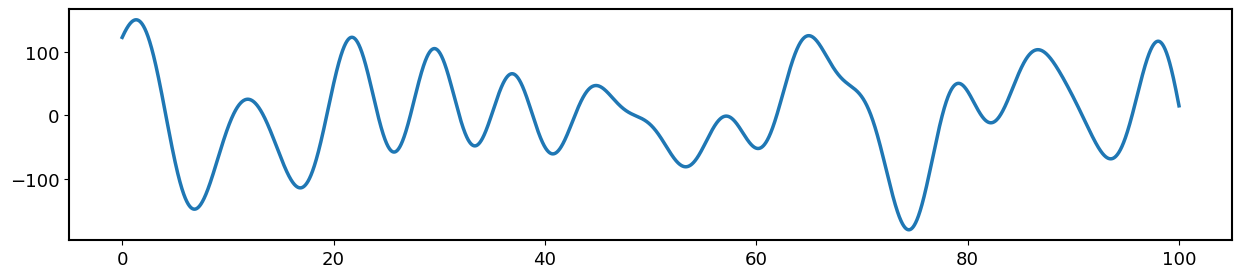

In [77]:
###############################
N = 10000
dt = 1e-2
pi = np.pi
nb_parts = 100
phi = rnd.uniform(low=-pi, high=pi, size=nb_parts)
f = rnd.uniform(low=.02, high=.15, size=nb_parts)*dt
A = rnd.uniform(low=-pi, high=pi, size=nb_parts)
###############################
time = np.arange(0,N,1)
t = np.arange(0,N*dt,dt)
pend1 = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(0),0]), dt=dt)
pend2 = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(60),0]), dt=dt)
###############################
x_train = 0
for i in range(nb_parts):
    x_train = x_train + A[i]*np.sin(2*pi*f[i]*time + phi[i])
    
x_train = x_train/max(max(x_train),-min(x_train))*pi
pend1.ref = x_train
###############################
fig, ax = plt.subplots(ncols=1, figsize=(15,3))
ax.plot(t,rad2deg(x_train))

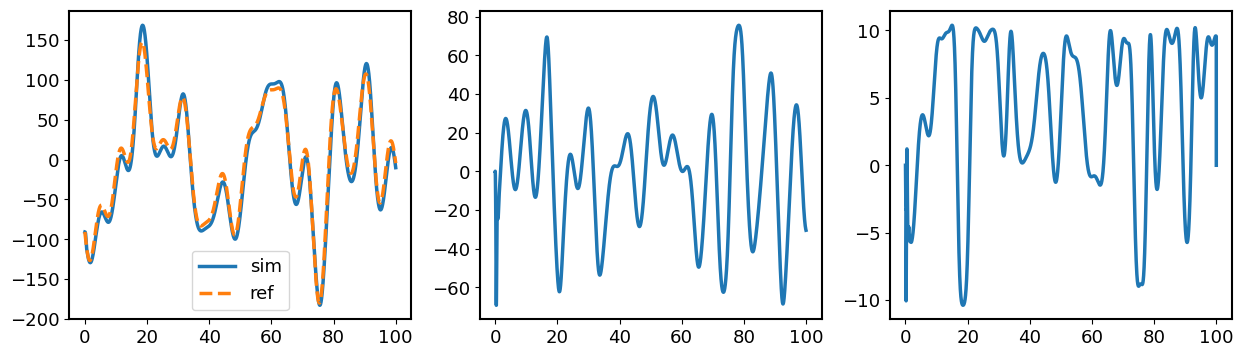

In [74]:
Kp, Ki, Kd = 50, 20, 5
U_train = np.zeros(shape=[N])
X_train = np.zeros(shape=[2,N])
X_train[0,0] = x_train[0]
# pend1.ref = np.array(sineReference(pend1.N, pend1.dt, 1/.2/dt, 40, 70))
# x_train = pend1.ref
# X_train[:,0] = np.array([deg2rad(70),0])
##############################################
for i in range(N-1):
    U_train[i] = PID(X_train, i, x_train[i], Kp, Kd, Ki, pend1.dt, 20, limit=[-20,20])[0] 
    X_train[:,i+1] = RK4(pend1.dynamics, X_train[:,i], U_train[i], pend1.dt, type='controller-step-by-step')
#         pend2.U[i] = PID(pend2.X, i, pend2.ref[i], 60, 11, 25, pend2.dt, 40, limit=200)[0]
#         pend2.X[:,i+1] = RK4(pend2.dynamics, pend2.X[:,i], pend2.U[i], pend2.dt, type='controller-step-by-step')
pend1.X = X_train
pend1.U = U_train
##############################################
fig, ax = plt.subplots(ncols=3, figsize=(15,4))

ax[0].plot(t,rad2deg(X_train[0,:]),label='sim'), ax[0].plot(t,rad2deg(x_train),linestyle='dashed',label='ref'),ax[0].legend()
ax[1].plot(t,rad2deg(X_train[1,:]))
ax[2].plot(t,U_train)

## State dimension lifting

In [75]:
#########################################
pend = pend1
ny, nu = 30,10
n_max = max(ny,nu)
n = 2*ny + nu - 1
Z, Y = np.empty(shape=[n,pend.N - n_max - 1]), np.empty(shape=[n,pend.N - n_max - 1])
#########################################
for i in range(pend.N-n_max-1):
    Z[0:2*ny:2,i], Y[0:2*ny:2,i] = pend.X[0,ny+i:i:-1], pend.X[0,ny+i+1:i+1:-1]
    Z[1:2*ny:2,i], Y[1:2*ny:2,i] = pend.X[1,ny+i:i:-1], pend.X[1,ny+i+1:i+1:-1]
    Z[2*ny:,i], Y[2*ny:,i] = pend.U[nu+i-1:i:-1], pend.U[nu+i:i+1:-1]
U = pend.U[:pend.N-ny-1]
U = pend.U[ny:pend.N-1]
U = U[:,np.newaxis]

XU = np.concatenate((Z,U.T),axis=0)
#########################################
AB = Y@pinv(XU)
A, B = AB[:,:n], AB[:,n]
B = B[:,np.newaxis]
#########################################
# Xp = X[:,0]
# Xp = Xp[:,np.newaxis]
# Xb = pend.X[:,ny]
# Xb = Xb[:,np.newaxis]
# C = Xb@pinv(Xp)
# C = np.concatenate((np.eye(2),np.zeros(shape=[2,n - 2])),axis=1)
C = pend.X[:,ny:pend.N-1]@pinv(Z)

## Simulation in lifted space

In [76]:
#########################################
X0 = pend.X[:,0]
Z0 = pinv(C)@X0
print(X0,Z0)
Z_traj = np.empty(shape=[n,pend.N])
Z_traj[:,0] = Z0
#########################################
for i in range(pend.N-1):
    Z_traj[:,i+1] = A@Z_traj[:,i] + B.T*pend.U[i]
#########################################
X_traj = C@Z_traj

[-1.58632  0.     ] [-1.60008e+00  3.52402e-04 -3.15603e-01  4.86105e-03  1.27865e-01
 -1.46951e-02  1.53248e-01  2.71453e-02  3.57343e-02 -1.94976e-02
 -6.76464e-02 -1.11305e-02 -9.28880e-02  2.94411e-02 -4.50612e-02
 -2.31659e-02  2.88912e-02  9.81888e-03  6.30377e-02 -1.34581e-03
  3.49816e-02 -2.17010e-04 -1.08358e-02 -3.76504e-04 -3.04344e-02
 -1.70686e-04 -2.06626e-02  7.99722e-05  4.71571e-04  1.83360e-04
  1.71331e-02  9.36672e-05  1.61388e-02 -7.07724e-05 -1.15817e-03
 -1.43747e-04 -1.70171e-02 -4.90226e-05 -1.41556e-02  1.07614e-04
  7.55191e-04  1.32920e-04  1.17784e-02  2.91016e-04  1.25742e-02
 -4.34849e-04  9.47193e-03  6.80153e-04  1.37730e-03 -1.13858e-03
 -6.77955e-03  5.92149e-04 -1.18623e-02 -3.91050e-04 -1.19865e-02
  1.38547e-04 -1.71917e-03  1.49146e-04  1.26481e-02  4.69889e-05
  4.50686e-07 -1.43254e-06  2.93536e-06 -5.01210e-06  4.87348e-06
 -2.53120e-06  8.59364e-07  2.09361e-07 -2.39102e-07]


<ipython-input-76-3a2529a856bd>:9: RuntimeWarning: overflow encountered in matmul
  Z_traj[:,i+1] = A@Z_traj[:,i] + B.T*pend.U[i]
<ipython-input-76-3a2529a856bd>:9: RuntimeWarning: invalid value encountered in matmul
  Z_traj[:,i+1] = A@Z_traj[:,i] + B.T*pend.U[i]
